# Modelos kNN para el mercado inmobiliario

En el presente notebook investigamos distintos tipos de modelos kNN para predecir los valores de las propiedades en el mercado inmobiliario de Buenos Aires. El modelo kNN, por su naturaleza, captura la intuición habitual con respecto a la determinación de los precios de las propiedades: que lo más determinante es la zona en la que se encuentran. Asimismo, pareciera ser el modelo que utiliza [Properati](https://www.properati.com.ar/data/) (de donde fueron extraídos los datos del presente notebook) para su [preciómetro](https://www.properati.com.ar/tools/valuador-propiedades).

In [1]:
import os
# import warnings
# warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Properati_data_clean.csv')
df.head()

,index,created_on,lat,lon,barrio_publicado,rooms,surface_total,surface_covered,price,title,...,VILLA LURO,VILLA ORTUZAR,VILLA PUEYRREDON,VILLA REAL,VILLA RIACHUELO,VILLA SANTA RITA,VILLA SOLDATI,VILLA URQUIZA,surface_uncovered,price_m2
0,0,2019-08-04,-34.601864,-58.443563,Villa Crespo,3.0,67.0,60.0,110000.0,Departamento venta,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1732.283465
1,1,2019-08-04,-34.644735,-58.421061,Boedo,2.0,40.0,40.0,79900.0,Departamento - Boedo - 2 amb MUY LUMINOSO!! ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997.500000
2,2,2019-08-04,-34.603423,-58.431140,Almagro,2.0,38.0,38.0,112000.0,Dos Ambientes Reciclado a 1 cuadra del Subte B,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2947.368421
3,3,2019-08-04,-34.609326,-58.492374,Villa del Parque,2.0,94.0,77.0,169000.0,PH DE 3 PLANTAS CON COCHERA PROPIA Y TERRAZA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1976.608187
4,4,2019-05-27,-34.629607,-58.439279,NaN,1.0,41.0,37.0,118000.0,Departamento venta,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3025.641026


In [3]:
# Chequeo columnas
df.columns

Index(['index', 'created_on', 'lat', 'lon', 'barrio_publicado', 'rooms',
       'surface_total', 'surface_covered', 'price', 'title', 'description',
       'property_type', 'barrio', 'densidad', 'NBI', 'Casa', 'Departamento',
       'PH', 'AGRONOMIA', 'ALMAGRO', 'BALVANERA', 'BARRACAS', 'BELGRANO',
       'BOCA', 'BOEDO', 'CABALLITO', 'CHACARITA', 'COGHLAN', 'COLEGIALES',
       'CONSTITUCION', 'FLORES', 'FLORESTA', 'LINIERS', 'MATADEROS',
       'MONSERRAT', 'MONTE CASTRO', 'NUEVA POMPEYA', 'NUNEZ', 'PALERMO',
       'PARQUE AVELLANEDA', 'PARQUE CHACABUCO', 'PARQUE CHAS',
       'PARQUE PATRICIOS', 'PATERNAL', 'PUERTO MADERO', 'RECOLETA', 'RETIRO',
       'SAAVEDRA', 'SAN CRISTOBAL', 'SAN NICOLAS', 'SAN TELMO',
       'VELEZ SARSFIELD', 'VERSALLES', 'VILLA CRESPO', 'VILLA DEL PARQUE',
       'VILLA DEVOTO', 'VILLA GRAL. MITRE', 'VILLA LUGANO', 'VILLA LURO',
       'VILLA ORTUZAR', 'VILLA PUEYRREDON', 'VILLA REAL', 'VILLA RIACHUELO',
       'VILLA SANTA RITA', 'VILLA SOLDATI', 'VILLA U

In [4]:
# Me quedo con las columnas que me interesan
features = ['lat', 'lon','surface_covered','surface_uncovered','rooms','NBI','densidad','Casa', 'Departamento','PH',]
barrios = ['BALVANERA','VILLA LUGANO','CONSTITUCION','FLORES','BOCA','NUNEZ','BELGRANO','RECOLETA','PALERMO']
targets = ['price_m2','price',]
columnas = features + barrios + targets
df = df[columnas]
df.head()

,lat,lon,surface_covered,surface_uncovered,rooms,NBI,densidad,Casa,Departamento,PH,...,VILLA LUGANO,CONSTITUCION,FLORES,BOCA,NUNEZ,BELGRANO,RECOLETA,PALERMO,price_m2,price
0,-34.601864,-58.443563,60.0,7.0,3.0,0.74,21699.484109,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1732.283465,110000.0
1,-34.644735,-58.421061,40.0,0.0,2.0,5.80,11797.712026,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997.500000,79900.0
2,-34.603423,-58.431140,38.0,0.0,2.0,0.92,63288.443473,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2947.368421,112000.0
3,-34.609326,-58.492374,77.0,17.0,2.0,0.27,13914.638078,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1976.608187,169000.0
4,-34.629607,-58.439279,37.0,4.0,1.0,6.03,20216.713377,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3025.641026,118000.0


In [5]:
df.dropna(inplace=True)
df.isna().sum()

lat                  0
lon                  0
surface_covered      0
surface_uncovered    0
rooms                0
NBI                  0
densidad             0
Casa                 0
Departamento         0
PH                   0
BALVANERA            0
VILLA LUGANO         0
CONSTITUCION         0
FLORES               0
BOCA                 0
NUNEZ                0
BELGRANO             0
RECOLETA             0
PALERMO              0
price_m2             0
price                0
dtype: int64

### Train test split

In [6]:
from sklearn.model_selection import train_test_split

# Shuffleamos
np.random.seed(seed=49)
df_perm = np.random.permutation(df)
df = pd.DataFrame(df_perm,columns=df.columns)

# Vamos a dividir en tres conjuntos: train, validation, test
df_train, df_val_test = train_test_split(df,test_size=0.3,random_state=50)
df_validation, df_test = train_test_split(df_val_test,test_size=0.5,random_state=51)

In [7]:
# Tomaremos como target la variable precio, y como input todo lo demás
X_train = df_train.drop(columns=['price','price_m2'])
X_validation = df_validation.drop(columns=['price','price_m2'])
X_test = df_test.drop(columns=['price','price_m2'])
y_train = df_train['price']
y_validation = df_validation['price'] 
y_test = df_test['price']

### kNN default

A continuación aplicamos el regresor kNN (con los parámetros default de sklearn) a nuestros datos. Como es habitual, escalaremos los datos antes de fitear el kNN.

El score que utilizaremos para evaluar nuestros modelos será el RMSE (root mean squared error), aunque también indicaremos el R2 cuando ello resulte adecuado.

In [8]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.preprocessing import StandardScaler


# Estandarizamos los datos
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)
 
# Aplicamos KNN
knr1 = KNR()
knr1.fit(X_train_scaled,y_train)
y_train_pred_knr1 = knr1.predict(X_train_scaled)
y_test_pred_knr1 = knr1.predict(X_test_scaled)

# Calculamos RMSE y R2
rmse_knr1_train = np.sqrt(mean_squared_error(y_train,y_train_pred_knr1))
rmse_knr1_test = np.sqrt(mean_squared_error(y_test,y_test_pred_knr1))
r2_knr1_train = r2_score(y_train,y_train_pred_knr1)
r2_knr1_test = r2_score(y_test,y_test_pred_knr1)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_knr1_train}")
print(f"El RMSE en el conjunto de test es {rmse_knr1_test}")
print(f"El R2 en el conjunto de train es {r2_knr1_train}")
print(f"El R2 en el conjunto de test es {r2_knr1_test}")

El RMSE en el conjunto de train es 30080.518447504484
El RMSE en el conjunto de test es 36421.503825956315
El R2 en el conjunto de train es 0.8680893168092587
El R2 en el conjunto de test es 0.8076601885618133


Este modelo inicial será nuestro benchmark. Durante el resto del notebook trabajaremos en mejorar su performance.

### Optimización de parámetros: encontrando el k óptimo con Grid Search

Más arriba calculamos el modelo kNN con los valores default de sci-kit learn; en particular, se toma n_neghbors = 5. A su vez, realizamos el cálculo de nuestros scores solamente para los conjuntos de train y test, lo que podría hacer que nuestros resultados sean muy sensibles a dicha partición. 

En este apartado nos dedicamos a refinar nuestro modelo: calcularemos scores de cross validation para distintos valores de k, tanto para el modelo escalado como sin escalar, pudiendo así tener un scoring más robusto (a través del cross validation) y mejor (a través del hyperparameter tuning).

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate

# Creamos un pipeline que escale cada fold de cross validation
# De este modo no leakeamos datos del train fold al test fold
knr_pipe = Pipeline([('scaler',StandardScaler()),('knr',KNR())])
knr_pipe.fit(X_train,y_train)
knr_scores = np.sqrt(-cross_val_score(knr_pipe, X_train, y_train, cv=5,scoring='neg_mean_squared_error'))

print(f'Score promedio: {knr_scores.mean()}')

Score promedio: 38311.77000442967


Los resultados en efecto son similares a los anteriores (aunque ambos empeoraron, posiblemente por reducir el tamaño de muestra para cada fold y porque puede haber folds con mucho error que inflen el promedio).

Seguimos con el hyperparameter tuning, a través del GridSearchCV de sci-kit learn. Vamos a variar tanto el numero de vecinos como la función de peso (weight), que establece la naturaleza del voting de predicción entre los vecinos más cercanos.

In [10]:
from sklearn.model_selection import GridSearchCV

k_grid1 = {'knr__n_neighbors':[5,10,15,20],'knr__weights':['uniform','distance']}
# Hacemos dos folds en un rango amplio, para estrechar luego la búsqueda
grid1 = GridSearchCV(knr_pipe,k_grid1,scoring='neg_mean_squared_error',cv=2,n_jobs=-1)
grid1.fit(X_train,y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
  

In [11]:
df_scores1 = pd.DataFrame(grid1.cv_results_)
df_scores1 = df_scores1[['param_knr__n_neighbors','param_knr__weights','mean_test_score','rank_test_score']]
df_scores1.rename({'param_knr__n_neighbors':'k','param_knr__weights':'weights'},inplace=True,axis=1)
df_scores1['rmse'] = np.sqrt(-df_scores1['mean_test_score'])
df_scores1.drop(columns='mean_test_score',inplace=True)
df_scores1.sort_values(by='rmse')

,k,weights,rank_test_score,rmse
3,10,distance,1,35702.749314
5,15,distance,2,35761.223868
7,20,distance,3,35939.015261
1,5,distance,4,36418.053578
0,5,uniform,5,39458.458544
2,10,uniform,6,39595.917797
4,15,uniform,7,40022.384638
6,20,uniform,8,40403.498983


Vamos a plotear un heatmap con este dataframe.

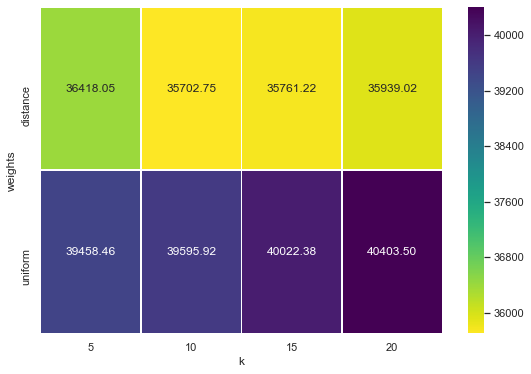

In [12]:
sns.set()
df_heat = df_scores1.drop(columns='rank_test_score').groupby(['weights','k'])
df_heat = df_heat['rmse'].sum().unstack()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_heat, annot=True, linewidths=.5, cmap='viridis_r', ax=ax, fmt='.2f')

Como nos muestra el heatmap, ponderar por la distancia nos está dando mejores resultados. En cuanto al número de vecinos, el óptimo parece estar alrededor de 10. Ahora aumentamos los folds de cv.

In [13]:
knr_pipe = Pipeline([('scaler',StandardScaler()),('knr',KNR(weights='distance'))])
k_grid2 = {'knr__n_neighbors':range(8,15),}
grid2 = GridSearchCV(knr_pipe,k_grid2,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
grid2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='distance'))],
                                verbose=False),
 

In [14]:
df_scores2 = pd.DataFrame(grid2.cv_results_)
df_scores2 = df_scores2[['param_knr__n_neighbors','mean_test_score','rank_test_score']]
df_scores2.rename({'param_knr__n_neighbors':'k'},inplace=True,axis=1)
df_scores2['rmse'] = np.sqrt(-df_scores2['mean_test_score'])
df_scores2.drop(columns='mean_test_score',inplace=True)
df_scores2.sort_values(by='rmse')

,k,rank_test_score,rmse
5,13,1,33552.219514
4,12,2,33557.967804
6,14,3,33581.816792
3,11,4,33600.413137
2,10,5,33606.686920
1,9,6,33677.319482
0,8,7,33732.960875


Veámoslo gráficamente.

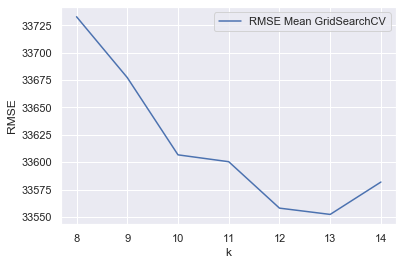

In [15]:
plt.plot(df_scores2.k,df_scores2.rmse,label='RMSE Mean GridSearchCV')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()

Del hyperparameter tuning, nos quedamos con n_neighbors = 13 y weights = distance. Este será nuestro segundo modelo, grid2. Lo evaluamos en nuestro conjunto de test.

In [16]:
# Aplicamos KNN
knr2 = KNR(n_neighbors=13,weights='distance')
knr2.fit(X_train_scaled,y_train)
y_train_pred_knr2 = knr2.predict(X_train_scaled)
y_test_pred_knr2 = knr2.predict(X_test_scaled)

# Calculamos RMSE y R2
rmse_knr2_train = np.sqrt(mean_squared_error(y_train,y_train_pred_knr2))
rmse_knr2_test = np.sqrt(mean_squared_error(y_test,y_test_pred_knr2))
r2_knr2_train = r2_score(y_train,y_train_pred_knr2)
r2_knr2_test = r2_score(y_test,y_test_pred_knr2)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_knr2_train}")
print(f"El RMSE en el conjunto de test es {rmse_knr2_test}")
print(f"El R2 en el conjunto de train es {r2_knr2_train}")
print(f"El R2 en el conjunto de test es {r2_knr2_test}")
print('Mejora benchmark: %.2f'% (((rmse_knr1_test - rmse_knr2_test)/rmse_knr1_test)*100)+' %')

El RMSE en el conjunto de train es 2427.106075555156
El RMSE en el conjunto de test es 31406.287006433075
El R2 en el conjunto de train es 0.9991412102545146
El R2 en el conjunto de test es 0.8569833407648588
Mejora benchmark: 13.77 %


## Bagging

Mejoramos la performance, pero tenemos también un gran overfitting del conjunto de test. Esta alta varianza sugiere la posibilidad de explorar un ensamble para modelos de bajo bias y alta variance: Bagging Regressor.

In [17]:
from sklearn.ensemble import BaggingRegressor

In [18]:
bag1 = BaggingRegressor(base_estimator=knr2,max_samples=0.5,\
                       max_features=0.7,n_estimators=100,n_jobs=-1)
bag1.fit(X_train_scaled,y_train)
y_train_pred_bag1 = bag1.predict(X_train_scaled)
y_test_pred_bag1 = bag1.predict(X_test_scaled)

In [19]:
# Calculamos RMSE y R2
rmse_bag1_train = np.sqrt(mean_squared_error(y_train,y_train_pred_bag1))
rmse_bag1_test = np.sqrt(mean_squared_error(y_test,y_test_pred_bag1))
r2_bag1_train = r2_score(y_train,y_train_pred_bag1)
r2_bag1_test = r2_score(y_test,y_test_pred_bag1)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_bag1_train}")
print(f"El RMSE en el conjunto de test es {rmse_bag1_test}")
print(f"El R2 en el conjunto de train es {r2_bag1_train}")
print(f"El R2 en el conjunto de test es {r2_bag1_test}")
print('Mejora benchmark: %.2f'% (((rmse_knr1_test - rmse_bag1_test)/rmse_knr1_test)*100)+' %')

El RMSE en el conjunto de train es 20832.56641276709
El RMSE en el conjunto de test es 33329.46973797159
El R2 en el conjunto de train es 0.936730429651417
El R2 en el conjunto de test es 0.8389316361426375
Mejora benchmark: 8.49 %


Vemos alguna mejora en nuestra performance. Probamos con otros parámetros.

In [20]:
bag2 = BaggingRegressor(base_estimator=knr2,max_samples=0.8,\
                       max_features=0.9,n_estimators=100,n_jobs=-1)
bag2.fit(X_train_scaled,y_train)
y_train_pred_bag2 = bag2.predict(X_train_scaled)
y_test_pred_bag2 = bag2.predict(X_test_scaled)

In [21]:
# Calculamos RMSE y R2
rmse_bag2_train = np.sqrt(mean_squared_error(y_train,y_train_pred_bag2))
rmse_bag2_test = np.sqrt(mean_squared_error(y_test,y_test_pred_bag2))
r2_bag2_train = r2_score(y_train,y_train_pred_bag2)
r2_bag2_test = r2_score(y_test,y_test_pred_bag2)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_bag2_train}")
print(f"El RMSE en el conjunto de test es {rmse_bag2_test}")
print(f"El R2 en el conjunto de train es {r2_bag2_train}")
print(f"El R2 en el conjunto de test es {r2_bag2_test}")
print('Mejora benchmark: %.2f'% (((rmse_knr1_test - rmse_bag2_test)/rmse_knr1_test)*100)+' %')

El RMSE en el conjunto de train es 14911.805617233853
El RMSE en el conjunto de test es 31929.58378929097
El R2 en el conjunto de train es 0.967583225282166
El R2 en el conjunto de test es 0.8521777005921809
Mejora benchmark: 12.33 %


Una mejora superior a la anterior, un poco por debajo del modelo optimizado. Podríamos hacer un Grid Search para ver si podemos mejorar la performance aún más.

### Prediciendo precio a través del precio por m2

Otra aproximación al problema sería tomar construir un modelo para predecir el precio por m2, y desde ahí estimar el precio de la propiedad. Es lo que haremos a continuación.

In [22]:
# Tomaremos como target la variable precio por m2
z_train = df_train['price_m2']
z_validation = df_validation['price_m2'] 
z_test = df_test['price_m2']

In [23]:
knr_pipe = Pipeline([('scaler',StandardScaler()),('knr',KNR(weights='distance'))])
k_grid2 = {'knr__n_neighbors':[5,10,15,20],}
# Hacemos dos folds en un rango amplio, para estrechar luego la búsqueda
grid3 = GridSearchCV(knr_pipe,k_grid2,scoring='neg_mean_squared_error',cv=2,n_jobs=-1)
grid3.fit(X_train,z_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='distance'))],
                                verbose=False),
 

In [24]:
df_scores3 = pd.DataFrame(grid3.cv_results_)
df_scores3 = df_scores3[['param_knr__n_neighbors','mean_test_score','rank_test_score']]
df_scores3

,param_knr__n_neighbors,mean_test_score,rank_test_score
0,5,-252481.454775,4
1,10,-236306.247899,3
2,15,-232486.136902,2
3,20,-230939.499115,1


In [25]:
# Seguimos buscando
knr_pipe = Pipeline([('scaler',StandardScaler()),('knr',KNR(weights='distance'))])
k_grid3 = {'knr__n_neighbors':[18,20,25,30],}
# Hacemos dos folds en un rango amplio, para estrechar luego la búsqueda
grid4 = GridSearchCV(knr_pipe,k_grid3,scoring='neg_mean_squared_error',cv=2,n_jobs=-1)
grid4.fit(X_train,z_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='distance'))],
                                verbose=False),
 

In [26]:
df_scores4 = pd.DataFrame(grid4.cv_results_)
df_scores4 = df_scores4[['param_knr__n_neighbors','mean_test_score','rank_test_score']]
df_scores4

,param_knr__n_neighbors,mean_test_score,rank_test_score
0,18,-231430.220524,4
1,20,-230939.499115,3
2,25,-230318.489960,1
3,30,-230933.793435,2


In [27]:
# Hilando fino
knr_pipe = Pipeline([('scaler',StandardScaler()),('knr',KNR(weights='distance'))])
k_grid4 = {'knr__n_neighbors':range(21,28)}
# Hacemos dos folds en un rango amplio, para estrechar luego la búsqueda
grid5 = GridSearchCV(knr_pipe,k_grid4,scoring='neg_mean_squared_error',cv=2,n_jobs=-1)
grid5.fit(X_train,z_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='distance'))],
                                verbose=False),
 

In [28]:
df_scores5 = pd.DataFrame(grid5.cv_results_)
df_scores5 = df_scores5[['param_knr__n_neighbors','mean_test_score','rank_test_score']]
df_scores5

,param_knr__n_neighbors,mean_test_score,rank_test_score
0,21,-230693.859933,6
1,22,-230389.325042,4
2,23,-230384.205833,3
3,24,-230171.411927,1
4,25,-230318.489960,2
5,26,-230565.504424,5
6,27,-230796.583598,7


Nuestro ganador es n=24, lo graficamos.

In [29]:
df_scores5['rmse'] = np.sqrt(-df_scores5['mean_test_score'])
df_scores5.rename({'param_knr__n_neighbors':'k'},inplace=True,axis=1)

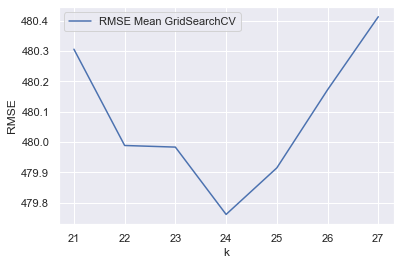

In [30]:
plt.plot(df_scores5.k,df_scores5.rmse,label='RMSE Mean GridSearchCV')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()

Vamos a predecir con este modelo la misma variable que en los anteriores, precio (en lugar de precio por m2), para poder comparar.

In [31]:
# Aplicamos KNN
knr3 = KNR(n_neighbors=24,weights='distance')
knr3.fit(X_train_scaled,z_train)
# Predecimos precio por m2
z_train_pred_knr3 = knr3.predict(X_train_scaled)
z_test_pred_knr3 = knr3.predict(X_test_scaled)
# Calculamos precio total, teniendo en cuenta la superficie
y_train_pred_knr3 = z_train_pred_knr3*(X_train['surface_covered'] + X_train['surface_uncovered']*0.5) 
y_test_pred_knr3 = z_test_pred_knr3*(X_test['surface_covered'] + X_test['surface_uncovered']*0.5) 

# Calculamos RMSE y R2
rmse_knr3_train = np.sqrt(mean_squared_error(y_train,y_train_pred_knr3))
rmse_knr3_test = np.sqrt(mean_squared_error(y_test,y_test_pred_knr3))
r2_knr3_train = r2_score(y_train,y_train_pred_knr3)
r2_knr3_test = r2_score(y_test,y_test_pred_knr3)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_knr3_train}")
print(f"El RMSE en el conjunto de test es {rmse_knr3_test}")
print(f"El R2 en el conjunto de train es {r2_knr3_train}")
print(f"El R2 en el conjunto de test es {r2_knr3_test}")
print('Mejora benchmark: %.2f'% (((rmse_knr1_test - rmse_knr3_test)/rmse_knr1_test)*100)+' %')

El RMSE en el conjunto de train es 2427.106075555156
El RMSE en el conjunto de test es 28965.104682398418
El R2 en el conjunto de train es 0.9991412102545146
El R2 en el conjunto de test es 0.8783523724362465
Mejora benchmark: 20.47 %


### Distancia Euclideana Ponderada

Otro conjunto de hiperparámetros "implícitos" en el modelo kNN son las ponderaciones de la distancia; es decir, cuánto pesa cada feature en el cálculo de la distancia entre dos data points. Probaremos algunas ponderaciones según dos medidas del "peso" de cada feature: correlación (en valor absoluto) y feature importance, extraída de un modelo Random Forest.

In [32]:
corr = df_train.corr('pearson')
corr_abs = abs(corr['price'])
corr_weights = corr_abs.values[0:-2]

In [33]:
# Aplicamos kNN con weighted euclidean distance
knr4 = KNR(n_neighbors=13,weights='distance',metric='wminkowski',metric_params={'w':corr_weights})
knr4.fit(X_train_scaled,y_train)
y_train_pred_knr4 = knr4.predict(X_train_scaled)
y_test_pred_knr4 = knr4.predict(X_test_scaled)

# Calculamos RMSE y R2
rmse_knr4_train = np.sqrt(mean_squared_error(y_train,y_train_pred_knr4))
rmse_knr4_test = np.sqrt(mean_squared_error(y_test,y_test_pred_knr4))
r2_knr4_train = r2_score(y_train,y_train_pred_knr4)
r2_knr4_test = r2_score(y_test,y_test_pred_knr4)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_knr4_train}")
print(f"El RMSE en el conjunto de test es {rmse_knr4_test}")
print(f"El R2 en el conjunto de train es {r2_knr4_train}")
print(f"El R2 en el conjunto de test es {r2_knr4_test}")
print('Mejora benchmark: %.2f'% (((rmse_knr1_test - rmse_knr4_test)/rmse_knr1_test)*100)+' %')

El RMSE en el conjunto de train es 2427.106075555156
El RMSE en el conjunto de test es 31044.32650415861
El R2 en el conjunto de train es 0.9991412102545146
El R2 en el conjunto de test es 0.8602609058915818
Mejora benchmark: 14.76 %


Interesante mejora. Ahora haremos lo mismo con el array de feature importances de Random Forest.

In [34]:
importance = [1.46950480e+03, 5.11196693e+02, 5.01101363e+03, 5.15047328e+02,\
 1.40625873e+03, 4.24962986e+02, 3.40308313e+02, 1.16980497e+01,\
 5.58928922e+01, 6.56886396e+01, 1.39077335e+01, 1.73843572e+01,\
 8.78352191e+00, 1.05221318e+01, 3.63225846e+00, 7.33607329e+00,\
 1.60968823e+01, 3.38647514e+01, 7.69002348e+01]

In [35]:
# Aplicamos kNN con weighted euclidean distance
knr5 = KNR(n_neighbors=13,weights='distance',metric='wminkowski',metric_params={'w':importance})
knr5.fit(X_train_scaled,y_train)
y_train_pred_knr5 = knr5.predict(X_train_scaled)
y_test_pred_knr5 = knr5.predict(X_test_scaled)

# Calculamos RMSE y R2
rmse_knr5_train = np.sqrt(mean_squared_error(y_train,y_train_pred_knr5))
rmse_knr5_test = np.sqrt(mean_squared_error(y_test,y_test_pred_knr5))
r2_knr5_train = r2_score(y_train,y_train_pred_knr5)
r2_knr5_test = r2_score(y_test,y_test_pred_knr5)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_knr5_train}")
print(f"El RMSE en el conjunto de test es {rmse_knr5_test}")
print(f"El R2 en el conjunto de train es {r2_knr5_train}")
print(f"El R2 en el conjunto de test es {r2_knr5_test}")
print('Mejora benchmark: %.2f'% (((rmse_knr1_test - rmse_knr5_test)/rmse_knr1_test)*100)+' %')

El RMSE en el conjunto de train es 2427.106075555156
El RMSE en el conjunto de test es 30941.67136895862
El R2 en el conjunto de train es 0.9991412102545146
El R2 en el conjunto de test es 0.8611835361956
Mejora benchmark: 15.05 %


Ahora utilizaremos este array importance para predecir con el precio por m2.

In [36]:
# Aplicamos KNN
knr6 = KNR(n_neighbors=24,weights='distance',metric='wminkowski',metric_params={'w':importance})
knr6.fit(X_train_scaled,z_train)
# Predecimos precio por m2
z_train_pred_knr6 = knr6.predict(X_train_scaled)
z_test_pred_knr6 = knr6.predict(X_test_scaled)
# Calculamos precio total, teniendo en cuenta la superficie
y_train_pred_knr6 = z_train_pred_knr6*(X_train['surface_covered'] + X_train['surface_uncovered']*0.5) 
y_test_pred_knr6 = z_test_pred_knr6*(X_test['surface_covered'] + X_test['surface_uncovered']*0.5) 

# Calculamos RMSE y R2
rmse_knr6_train = np.sqrt(mean_squared_error(y_train,y_train_pred_knr6))
rmse_knr6_test = np.sqrt(mean_squared_error(y_test,y_test_pred_knr6))
r2_knr6_train = r2_score(y_train,y_train_pred_knr6)
r2_knr6_test = r2_score(y_test,y_test_pred_knr6)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_knr6_train}")
print(f"El RMSE en el conjunto de test es {rmse_knr6_test}")
print(f"El R2 en el conjunto de train es {r2_knr6_train}")
print(f"El R2 en el conjunto de test es {r2_knr6_test}")
print('Mejora benchmark: %.2f'% (((rmse_knr1_test - rmse_knr6_test)/rmse_knr1_test)*100)+' %')

El RMSE en el conjunto de train es 2427.106075555156
El RMSE en el conjunto de test es 30790.022401581256
El R2 en el conjunto de train es 0.9991412102545146
El R2 en el conjunto de test es 0.8625409150808636
Mejora benchmark: 15.46 %


### Algoritmo adaptativo

Voy a tomar el modelo knr5 (distancia euclideana ponderada por la feature importance) y ver si podemos mejorar las ponderaciones adaptativamente.

In [37]:
# Esta función me indica el valor del RMSE para una lista de ponderaciones dada
def rmse_weights(sets,weight_list,n):
    '''
    Devuelve el RMSE para un conjunto de sets (train, test) y un listado de ponderaciones.
    
    sets: 4-tuple X_train,y_train,X_test,y_test
    weight_list: weighted values for euclidean metric
    n: neighbor parameters for KNR
    
    '''
    knr_weight = KNR(n_neighbors=n,metric='wminkowski', p=2,metric_params={'w': weight_list})
    knr_weight.fit(sets[0],sets[1])
    y_test_pred = knr_weight.predict(sets[2])
    rmse_test = np.sqrt(mean_squared_error(y_test_pred, sets[3]))
    return rmse_test

In [38]:
# Esta función se encarga de mejorar nuestras ponderaciones, reduciendo el RMSE (test)
# Tiene un parámetro, time_limit, con el cual puedo indicar cuánto tiempo le voy a dar para optimizar

import time

def improve_rmse(sets,weight_list,delta=0.1,n=5,time_limit=60):
    '''
    Devuelve pesos mejorados para un modelo KNR con distancia euclideana ponderada.
    
    sets: 4-tuple (X_train,y_train,X_test,y_test)
    weight_list: weighted values for euclidean metric
    n: neighbor parameters for KNR
    delta: how much will each weight change (in percent)
    
    '''
    t0 = time.time()
    weight_work = weight_list.copy()
    initial_score = rmse_weights(sets,weight_list,n)
    score = initial_score
    # Realizo pequenios cambios (delta) en los weights (positivo/negativo)
    # Si mejoran el score, me quedo con el nuevo valor del weight
    while time.time() - t0 < time_limit:
        print('Tiempo: ',time.time()-t0,'\nRMSE: ',score) # para control
        last_score = score
        for j in range(len(weight_work)):
            if (time.time() - t0 > time_limit):
                break
            print('Tiempo: ',time.time()-t0,', j: ',j) # para control
            for change in [1+delta,1-delta]:
                weight_aux = weight_work.copy()
                weight_aux[j] = weight_aux[j]*change
                score_aux = rmse_weights(sets,weight_aux,n)
                if score_aux < score:
                    weight_work = weight_aux
                    score = score_aux
        # Si el score no mejora, aumento el delta
        if score == last_score:
            delta = delta*2
    return weight_work, score, initial_score

In [39]:
# Voy a usar la función para hallar ponderaciones que mejoren el scoring
# Nuestro benchmark es un KNR con k=13 y con ponderaciones = feature importance
# Como conjunto para mejorar tomamos df_validation, para no overfittear df_test
# Le voy a dar 10 minutos para evolucionar

X_validation_scaled = scaler1.transform(X_validation)
sets = (X_train_scaled,y_train,X_validation_scaled,y_validation)
weight_init = [int(x) for x in importance] # pesos feature importance, en enteros
results = improve_rmse(sets,weight_init,delta=0.5,n=13,time_limit=600)
ponderaciones = results[0]
print('Ponderaciones: ',ponderaciones)
print('RMSE test mejorado: ',results[1])
print('Mejora initial score: %.2f'% (((results[2] - results[1])/results[2])*100)+' %')

Tiempo:  63.66278696060181 
RMSE:  37062.29947520749
Tiempo:  63.66278696060181 , j:  0
Tiempo:  195.02241134643555 , j:  1
Tiempo:  329.07297444343567 , j:  2
Tiempo:  455.26107811927795 , j:  3
Tiempo:  584.8020446300507 , j:  4
Ponderaciones:  [2203.5, 766.5, 2505.5, 515, 703.0, 424, 340, 11, 55, 65, 13, 17, 8, 10, 3, 7, 16, 33, 76]
RMSE test mejorado:  34975.920820834006
Mejora initial score: 5.63 %


Ahora lo utilizamos en nuestros conjuntos originales.

In [40]:
# Aplicamos kNN con weighted euclidean distance
knr7 = KNR(n_neighbors=13,weights='distance',metric='wminkowski',metric_params={'w':ponderaciones})
knr7.fit(X_train_scaled,y_train)
y_train_pred_knr7 = knr7.predict(X_train_scaled)
y_test_pred_knr7 = knr7.predict(X_test_scaled)

# Calculamos RMSE y R2
rmse_knr7_train = np.sqrt(mean_squared_error(y_train,y_train_pred_knr7))
rmse_knr7_test = np.sqrt(mean_squared_error(y_test,y_test_pred_knr7))
r2_knr7_train = r2_score(y_train,y_train_pred_knr7)
r2_knr7_test = r2_score(y_test,y_test_pred_knr7)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_knr7_train}")
print(f"El RMSE en el conjunto de test es {rmse_knr7_test}")
print(f"El R2 en el conjunto de train es {r2_knr7_train}")
print(f"El R2 en el conjunto de test es {r2_knr7_test}")
print('Mejora benchmark: %.2f'% (((rmse_knr1_test - rmse_knr7_test)/rmse_knr1_test)*100)+' %')

El RMSE en el conjunto de train es 2427.106075555156
El RMSE en el conjunto de test es 29525.07899773691
El R2 en el conjunto de train es 0.9991412102545146
El R2 en el conjunto de test es 0.8736033466106978
Mejora benchmark: 18.94 %


## Apéndice: exportando información para mapas interactivos

In [41]:
# Sampleo subconjunto de test para mapa interactivo
# Quiero una muestra de tamaño 80 aprox

descarte,sample = train_test_split(df_test,test_size=0.02,random_state=11)
X_sample = sample.drop(columns=['price','price_m2'])
y_sample = sample.price
X_sample_scaled = scaler1.transform(X_sample)
X_sample.shape[0]

77

A continuación exportamos los datos de esta muestra para utilizar en el mapa interactivo.

In [42]:
# Exporto datos de muestra para mapa (index, lat, lon, price, price_m2, surface)
index_list,lat_list,lon_list,price_list,price_m2_list,surface_list = [],[],[],[],[],[]
# Uso la referencia de índices del df original
for j in (X_sample.index):
    lat,lon = X_sample.at[j,'lat'],X_sample.at[j,'lon']
    surface = X_sample.at[j,'surface_covered']
    price = df_test.at[j,'price']
    price_m2 = df_test.at[j,'price'] / (df_test.at[j,'surface_covered'] + df_test.at[j,'surface_covered']*0.5)
    index_list.append(j),lat_list.append(lat),lon_list.append(lon)
    price_list.append(price),price_m2_list.append(round(price_m2,2)),surface_list.append(surface)

# This is a javascript object
sampleList = {
    'index':index_list,
    'lat':lat_list,
    'lon':lon_list,
    'price':price_list,
    'price_m2':price_m2_list,
    'surface':surface_list,
}

with open('samplekNN.txt', 'w') as file:
        file.write('var sampleList = '+str(sampleList))

La función de la celda siguiente nos crea las predicciones detalladas para los mapas interactivos.

In [43]:
def create_prediction_javascript(predictions,neighbors_ind,filename,var_name):
    # Create lists:
    neigh_lat_list_list, neigh_lon_list_list = [],[]
    neigh_price_m2_list_list, neigh_surf_list_list = [],[]
    neigh_mean_surf_list,neigh_mean_price_m2_list = [],[]
    target_surf_list,target_price_m2_list = [],[]
    pred_price_list,target_price_list = [],[]
    
    # Loop each element from the sample, add its data and the prediction's
    for i, j in zip(range(X_sample.shape[0]),X_sample.index):
        neighbors = df.iloc[neighbors_ind[i],:]
        neighbors['price_m2'] = round(neighbors['price'] / (neighbors['surface_covered']+0.5*neighbors['surface_uncovered']),2)
        surf_mean = neighbors['surface_covered'].mean()
        price_m2_mean = neighbors['price_m2'].mean()
        price_mean = neighbors['price'].mean()
        price_m2_target = df.at[j,'price'] / (df_test.at[j,'surface_covered'] + df_test.at[j,'surface_covered']*0.5)
        lat_list = list(neighbors['lat'])
        lat_list.append(df.at[j,'lat'])
        neigh_lat_list_list.append(lat_list)
        lon_list = list(neighbors['lon'])
        lon_list.append(df.at[j,'lon'])
        neigh_lon_list_list.append(lon_list)
        price_m2_list = list(neighbors['price_m2'])
        price_m2_list.append(price_m2_target)
        neigh_price_m2_list_list.append(price_m2_list)
        surface_total_list = list(neighbors['surface_covered'])
        surface_total_list.append(df.at[j,'surface_covered'])
        neigh_surf_list_list.append(surface_total_list)
        neigh_mean_surf_list.append(round(surf_mean))
        target_surf_list.append(df.at[j,'surface_covered'])
        neigh_mean_price_m2_list.append(round(price_m2_mean,2))
        target_price_m2_list.append(round(price_m2_target,2))
        pred_price_list.append(round(predictions[i],2))
        target_price_list.append(df.at[j,'price'])

    # javascript Object
    predictionObj = {
        'neigh_lat_list':neigh_lat_list_list,
        'neigh_lon_list':neigh_lon_list_list,
        'neigh_price_m2_list':neigh_price_m2_list_list,
        'neigh_surf_list':neigh_surf_list_list,
        'neigh_mean_surf':neigh_mean_surf_list,
        'target_surf':target_surf_list,
        'neigh_mean_price_m2':neigh_mean_price_m2_list,
        'target_price_m2':target_price_m2_list, 
        'pred_price':pred_price_list,
        'target_price':target_price_list,
    }
    
    with open(str(filename)+'.txt', 'w') as file:
            file.write('var '+str(var_name)+' = '+str(predictionObj))

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Predicciones para el Grid Search
predictions = knr2.predict(X_sample_scaled)
neighbors_ind = knr2.kneighbors(X_sample_scaled)[1]
create_prediction_javascript(predictions,neighbors_ind,'grid','grid')

In [46]:
# Predicciones para el modelo con precio por m2
price_m2_pred = knr3.predict(X_sample_scaled)
# Calculamos precio total, teniendo en cuenta la superficie
predictions = price_m2_pred*(X_sample['surface_covered'] + X_sample['surface_uncovered']*0.5)
predictions = predictions.values
neighbors_ind = knr3.kneighbors(X_sample_scaled)[1]
create_prediction_javascript(predictions,neighbors_ind,'target','target')

In [47]:
# Predicciones para el modelo con Bagging
bag_predictions = bag2.predict(X_sample_scaled)

In [48]:
predictionObj = {
        'neigh_lat_list':[],
        'neigh_lon_list':[],
        'neigh_price_m2_list':[],
        'neigh_surf_list':[],
        'neigh_mean_surf':[],
        'target_surf':[],
        'neigh_mean_price_m2':[],
        'target_price_m2':[],
        'pred_price':list(bag_predictions),
        'target_price':[],
    }
    
with open('bagging.txt', 'w') as file:
    file.write('var bagging = ' + str(predictionObj))

In [49]:
# Predicciones para el modelo con pesos = correlaciones
predictions = knr4.predict(X_sample_scaled)
neighbors_ind = knr4.kneighbors(X_sample_scaled)[1]
create_prediction_javascript(predictions,neighbors_ind,'correlation','correlation')

In [50]:
# Predicciones para el modelo Adaptive
predictions = knr7.predict(X_sample_scaled)
neighbors_ind = knr7.kneighbors(X_sample_scaled)[1]
create_prediction_javascript(predictions,neighbors_ind,'adaptive','adaptive')

### Errores: histograma

In [51]:
# Creamos dataframe con las predicciones de cada modelo
df_pred = df_test
df_pred['pred_grid'] = y_test_pred_knr2
df_pred['pred_bagging'] = y_test_pred_bag2
df_pred['pred_target'] = y_test_pred_knr3
df_pred['pred_correlation'] = y_test_pred_knr4
df_pred['pred_adaptive'] = y_test_pred_knr7
df_pred.head()

,lat,lon,surface_covered,surface_uncovered,rooms,NBI,densidad,Casa,Departamento,PH,...,BELGRANO,RECOLETA,PALERMO,price_m2,price,pred_grid,pred_bagging,pred_target,pred_correlation,pred_adaptive
20051,-34.566249,-58.435773,42.0,2.0,2.0,0.44,29699.316073,0.0,1.0,0.0,...,0.0,0.0,1.0,3372.093023,145000.0,175722.409825,172298.330775,156856.006793,172134.022894,158758.882963
5831,-34.589389,-58.432844,61.0,19.0,3.0,14.62,15852.996062,0.0,1.0,0.0,...,0.0,0.0,1.0,3120.567376,220000.0,261823.008135,249179.784396,239294.403200,277881.727786,235809.681662
15088,-34.563948,-58.493088,47.0,9.0,2.0,4.68,11931.125315,0.0,1.0,0.0,...,0.0,0.0,0.0,3592.233010,185000.0,154892.455080,153876.797042,159554.432176,167351.710535,153735.173950
21379,-34.559046,-58.475664,67.0,20.0,3.0,2.88,11832.936445,0.0,0.0,1.0,...,0.0,0.0,0.0,2467.532468,190000.0,212968.819446,204228.461492,209484.286092,217129.343347,239762.185641
15377,-34.573314,-58.486807,54.0,25.0,3.0,1.78,20794.036925,0.0,1.0,0.0,...,0.0,0.0,0.0,2631.578947,175000.0,204268.313680,202061.734417,193127.804597,203968.636536,190209.259698


In [52]:
# Calculamos sus errores
df_pred['err_grid'] = df_pred['price'] - df_pred['pred_grid']
df_pred['err_bagging'] = df_pred['price'] - df_pred['pred_bagging']
df_pred['err_target'] = df_pred['price'] - df_pred['pred_target']
df_pred['err_correlation'] = df_pred['price'] - df_pred['pred_correlation']
df_pred['err_adaptive'] = df_pred['price'] - df_pred['pred_adaptive']

In [53]:
df_pred.head()

,lat,lon,surface_covered,surface_uncovered,rooms,NBI,densidad,Casa,Departamento,PH,...,pred_grid,pred_bagging,pred_target,pred_correlation,pred_adaptive,err_grid,err_bagging,err_target,err_correlation,err_adaptive
20051,-34.566249,-58.435773,42.0,2.0,2.0,0.44,29699.316073,0.0,1.0,0.0,...,175722.409825,172298.330775,156856.006793,172134.022894,158758.882963,-30722.409825,-27298.330775,-11856.006793,-27134.022894,-13758.882963
5831,-34.589389,-58.432844,61.0,19.0,3.0,14.62,15852.996062,0.0,1.0,0.0,...,261823.008135,249179.784396,239294.403200,277881.727786,235809.681662,-41823.008135,-29179.784396,-19294.403200,-57881.727786,-15809.681662
15088,-34.563948,-58.493088,47.0,9.0,2.0,4.68,11931.125315,0.0,1.0,0.0,...,154892.455080,153876.797042,159554.432176,167351.710535,153735.173950,30107.544920,31123.202958,25445.567824,17648.289465,31264.826050
21379,-34.559046,-58.475664,67.0,20.0,3.0,2.88,11832.936445,0.0,0.0,1.0,...,212968.819446,204228.461492,209484.286092,217129.343347,239762.185641,-22968.819446,-14228.461492,-19484.286092,-27129.343347,-49762.185641
15377,-34.573314,-58.486807,54.0,25.0,3.0,1.78,20794.036925,0.0,1.0,0.0,...,204268.313680,202061.734417,193127.804597,203968.636536,190209.259698,-29268.313680,-27061.734417,-18127.804597,-28968.636536,-15209.259698


In [54]:
df_pred.to_csv('kNN_test_pred.csv',sep=',',columns=df_pred.columns,index=False)

In [55]:
err_list = ['err_grid','err_bagging','err_target','err_correlation','err_adaptive']
minx = np.amin(np.amin(df_pred[err_list]))
maxx = np.amax(np.amax(df_pred[err_list]))
fontdict = {'fontsize': 15,'fontweight' :'bold',}
for x in err_list:
    plt.figure(figsize=(6,5))
    plt.hist(df_pred[x])
    plt.xlim(minx,maxx)
    plt.ylim(0,2700)
    plt.title(x,fontdict=fontdict)
    plt.savefig('Imgs/hist_'+x+'.png')
    plt.close()

### Errores: mapa

In [56]:
# Importo geopandas, importo mapa de los barrios
import geopandas as gpd
map_df = gpd.read_file('barrios.csv')

In [57]:
for x in err_list:
    pd.set_option('display.float_format', lambda x: '%.0f' % x)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    # Scatter de las propiedades, color coded según price_m2
    df_pred.plot(kind="scatter", x="lon", y="lat", alpha=1,
        c=x, cmap=plt.get_cmap("jet"), colorbar=True,sharex=True, ax=ax)
    # Polígonos de los barrios
    map_df.plot(linewidth=0.7, ax=ax, edgecolor='0',facecolor='none')
    ax.axis('off')
    ax.set_title('Errores de '+x+' según ubicación', fontdict={'fontsize': '18', 'fontweight' : '3'})
    plt.savefig('Imgs/map_'+x+'.png')
    plt.close()

### Validation set

In [58]:
X_validation_scaled = scaler1.transform(X_validation)
y_validation_pred_knr2 = knr2.predict(X_validation_scaled)
y_validation_pred_bag2 = bag2.predict(X_validation_scaled)
y_validation_pred_knr3 = knr3.predict(X_validation_scaled)
y_validation_pred_knr4 = knr4.predict(X_validation_scaled)
y_validation_pred_knr7 = knr7.predict(X_validation_scaled)

In [59]:
df_pred_valid = df_validation
df_pred_valid['pred_grid'] = y_validation_pred_knr2
df_pred_valid['pred_bagging'] = y_validation_pred_bag2
df_pred_valid['pred_target'] = y_validation_pred_knr3
df_pred_valid['pred_correlation'] = y_validation_pred_knr4
df_pred_valid['pred_adaptive'] = y_validation_pred_knr7

In [60]:
df_pred_valid['err_grid'] = df_pred_valid['price'] - df_pred_valid['pred_grid']
df_pred_valid['err_bagging'] = df_pred_valid['price'] - df_pred_valid['pred_bagging']
df_pred_valid['err_target'] = df_pred_valid['price'] - df_pred_valid['pred_target']
df_pred_valid['err_correlation'] = df_pred_valid['price'] - df_pred_valid['pred_correlation']
df_pred_valid['err_adaptive'] = df_pred_valid['price'] - df_pred_valid['pred_adaptive']

In [61]:
df_pred_valid.to_csv('kNN_valid_pred.csv',sep=',',columns=df_pred_valid.columns,index=False)